In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
import seaborn as sns
from tqdm import tqdm
from collections import OrderedDict

from matplotlib import pyplot as plt
from helpers import flatten

In [3]:
sns.set(style="whitegrid")
plt.style.use('paper')
palette = 'Set2'

# comparing best/mean metric value

for each method and metric (e.g, "ham") pair, take the best value over all returned entries

In [4]:
OUR = 'LocalPolarization'
THEIR = 'FOCG'
def get_metric_values(graph, by='median'):
    assert by in ('median', 'best')
    df1 = pd.read_pickle('outputs/{}_seed_pair_aug_k200.pkl'.format(graph))
    df1 = df1[df1['k']==200]
    df2 = pd.read_pickle('outputs/focg_{}_aug.pkl'.format(graph))

    rows = []
    if by == 'best':
        rows.append(('beta', OUR, df1['beta'].min()))
        rows.append(('beta', THEIR, df2['beta'].min()))
        rows.append(('ham', OUR, df1['ham'].max()))
        rows.append(('ham', THEIR, df2['ham'].max()))
        rows.append(('pc', OUR, df1['pc'].max()))
        rows.append(('pc', THEIR, df2['pc'].max()))
    else:
        rows.append(('beta', OUR, df1['beta'].median()))
        rows.append(('beta', THEIR, df2['beta'].median()))
        rows.append(('ham', OUR, df1['ham'].median()))
        rows.append(('ham', THEIR, df2['ham'].median()))
        rows.append(('pc', OUR, df1['pc'].median()))
        rows.append(('pc', THEIR, df2['pc'].median()))        
        
    return rows


In [5]:
graphs = ('bitcoin', 'ref', 'slashdot', 'epinions', 'wikiconflict')
labels = ('bitcoin', 'referendum', 'slashdot', 'epinions', 'wikiconflict')

In [6]:
rows = []
for graph in graphs:
    some_rows = get_metric_values(graph, by='best')
    rows += [(graph, ) + r for r in some_rows]
df_by_best = pd.DataFrame(rows, columns=['graph', 'measure', 'method', 'value'])    

rows = []
for graph in graphs:
    some_rows = get_metric_values(graph, by='median')
    rows += [(graph, ) + r for r in some_rows]
df_by_mean = pd.DataFrame(rows, columns=['graph', 'measure', 'method', 'value'])    

In [7]:
key2label = dict(
    beta=r'$\beta$',
    ham='HAM',
    pc='Polarity'
)

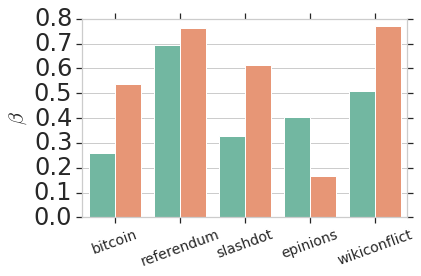

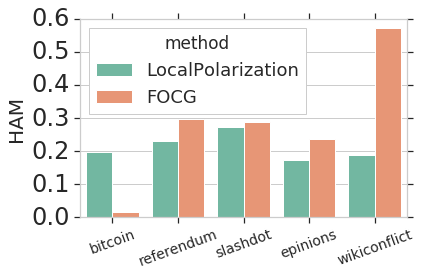

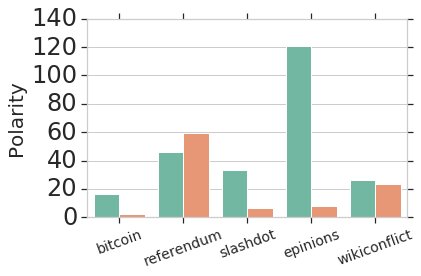

In [8]:
for key in ['beta', 'ham', 'pc']:
    fig, ax = plt.subplots(1, 1)
    bp = sns.barplot(
        x="graph", y="value", hue="method",
        data=df_by_best[df_by_best['measure'] == key],
        ax=ax, palette=palette
    )
    if key != 'ham':
        ax.legend_.remove()
    bp.set(ylabel=key2label[key], xlabel='')
    
    bp.set_xticklabels(labels, rotation=20, fontsize=14)
    fig.tight_layout()
    fig.savefig('figs/real_graph_exp/{}_by_best.pdf'.format(key))

# compare the distribution of the metric values

In [9]:
def exclude_overlapping_rows(df, by):
    """remove result that have overlaps"""
    non_overlapping_rows = []
    sorted_df = df.sort_values(by=by, ascending=False)
    covered_nodes = set()
    for i, r in tqdm(sorted_df.iterrows(), total=df.shape[0]):
        C = set(r['C1']) | set(r['C2'])
        if len(C.intersection(covered_nodes)) == 0:
            non_overlapping_rows.append(dict(r))
            covered_nodes |= C
    filtered_df = pd.DataFrame.from_records(non_overlapping_rows)
    return filtered_df


def filter_and_explode_metric_values(graph, by):    
    df1 = pd.read_pickle('outputs/{}_seed_pair_aug_k200.pkl'.format(graph))
    df2 = pd.read_pickle('outputs/focg_{}_aug.pkl'.format(graph))
    df1 = exclude_overlapping_rows(df1, by)
    
    rows = []
    for i, r in df1.iterrows():
        rows.append(('beta', OUR, r['beta']))
        rows.append(('ham', OUR, r['ham']))
        rows.append(('pc', OUR, r['pc']))
    for i, r in df2.iterrows():
        rows.append(('beta', THEIR, r['beta']))
        rows.append(('ham', THEIR, r['ham']))
        rows.append(('pc', THEIR, r['pc']))
    return rows   

In [26]:
complete_df_by_by = {}
for by in ('beta', 'ham', 'pc'):    
    rows = []
    for graph in graphs:
        some_rows = filter_and_explode_metric_values(graph, by)
        rows += [(graph, ) + r for r in some_rows]
    complete_df_by_by[by] = pd.DataFrame(rows, columns=['graph', 'measure', 'method', 'value'])
    


100%|██████████| 8288/8288 [00:02<00:00, 3607.17it/s]


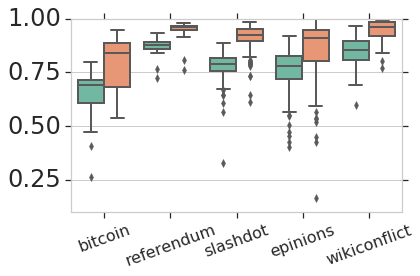

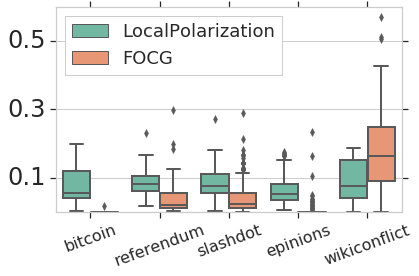

In [29]:
for by in ('beta', 'ham'):    
    fig, ax = plt.subplots(1, 1)
    bp = sns.boxplot(
        x="graph", y="value", hue="method",
        data=complete_df[complete_df['measure']==by],
        linewidth=2.0, fliersize=5.0,
        ax=ax, palette=palette
    )

    if by != 'ham':
        ax.legend_.remove()
        yticks = [0.25, 0.5, 0.75, 1.0]
    else:
        yticks = [0.1, 0.3, 0.5]
        ax.legend(loc='upper left')
        
    bp.set(xlabel='', ylabel='', yticks=yticks)
    bp.set_xticklabels(labels, rotation=20, fontsize=16)
    fig.tight_layout()
    fig.savefig('figs/real_graph_exp/{}_distributoin.pdf'.format(by))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


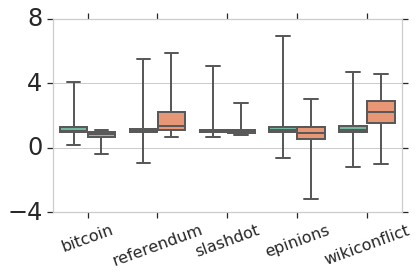

In [34]:
complete_df = complete_df_by_by['pc']
df_by_pc = complete_df[complete_df['measure']=='pc'].copy()
df_by_pc['value'] = np.log2(df_by_pc['value'])
df_by_pc.dropna(inplace=True)

fig, ax = plt.subplots(1, 1)
bp = sns.boxplot(
    x="graph", y="value", hue="method",
    data=df_by_pc,
    linewidth=2.0, fliersize=10.0,
    ax=ax, palette=palette, whis=100
)

ax.legend_.remove()

bp.set(ylabel='', xlabel='', yticks=[-4, 0, 4, 8])

bp.set_xticklabels(labels, rotation=20, fontsize=16)
fig.tight_layout()
fig.savefig('figs/real_graph_exp/pc_distributoin.pdf')

# querying nodes from good communities by FOCG

In [12]:
import random

from stat_helpers import *
from helpers import pos_adj, neg_adj
from core import query_graph_using_sparse_linear_solver, sweep_on_x_fast


def quick_stat(g, C1, C2):
    A = nx.adj_matrix(g, weight='sign')
    pos_A, neg_A = pos_adj(A), neg_adj(A)
    coh = cohe(pos_A, C1, C2)
    opp = oppo(neg_A, C1, C2)
    ham = 2 * coh * opp / (coh + opp)
    beta = sbr(pos_A - neg_A, C1, C2)
    print('ham {:.2f}'.format(ham))    
    print('beta {:.2f}'.format(beta))
    print('coh {:.2f}'.format(coh))
    print('opp {:.2f}'.format(opp))


    
def diff_sets(S1, S2):
    S1, S2 = map(set, (S1, S2))
    print('|S1|: ', len(S1))
    print('|S2|: ', len(S2))
    print('|S1 & S2|: ', len(S1.intersection(S2)))
    print('|S1 | S2|: ', len(S1 |S2))
    print('|S1 - S2|: ', len(S1 - S2))
    print('|S2 - S1|: ', len(S2 - S1))

In [13]:
def diff_graph(graph, idx=0):
    g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
    df = pd.read_pickle('outputs/focg_{}_aug.pkl'.format(graph))

    target_r = df.sort_values(by='ham', ascending=False).head(3).iloc[idx]
    target_r['C'] = list(target_r['C1']) + list(target_r['C2'])
    print(target_r[['ham', 'beta', 'opp', 'coh']])
    seed1 = random.choice(target_r['C1'])
    seed2 = random.choice(target_r['C2'])

    x, _ = query_graph_using_sparse_linear_solver(g, [[seed1], [seed2]], kappa=0.9, verbose=0, ub=g.graph['lambda1'])

    C1, C2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x_fast(g, x, top_k=100)

    diff_sets(C, target_r['C'])
    quick_stat(g, C1, C2)
    from viz_helpers import draw_query_result
    draw_query_result(g, C1, C2)

ham            1
beta    0.725572
opp            1
coh            1
Name: 0, dtype: object
|S1|:  36
|S2|:  12
|S1 & S2|:  12
|S1 | S2|:  36
|S1 - S2|:  24
|S2 - S1|:  0
ham 0.33
beta 0.66
coh 0.20
opp 0.93


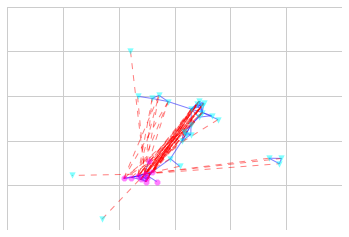

In [14]:
diff_graph('word')

ham     0.198582
beta    0.969178
opp     0.116667
coh     0.666667
Name: 5, dtype: object
|S1|:  37
|S2|:  16
|S1 & S2|:  2
|S1 | S2|:  51
|S1 - S2|:  35
|S2 - S1|:  14
ham 0.02
beta 0.91
coh 0.08
opp 0.01


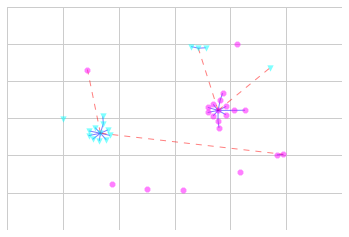

In [15]:
diff_graph('ref', idx=1)

ham     0.214414
beta    0.977949
opp     0.145833
coh     0.404762
Name: 6, dtype: object
|S1|:  42
|S2|:  20
|S1 & S2|:  2
|S1 | S2|:  60
|S1 - S2|:  40
|S2 - S1|:  18
ham 0.03
beta 0.84
coh 0.08
opp 0.02


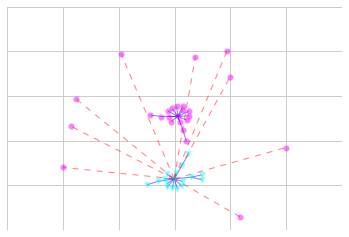

In [16]:
diff_graph('slashdot', idx=1)

ham     0.571429
beta    0.982823
opp            1
coh          0.4
Name: 5, dtype: object
|S1|:  100
|S2|:  19
|S1 & S2|:  2
|S1 | S2|:  117
|S1 - S2|:  98
|S2 - S1|:  17
ham 0.02
beta 0.95
coh 0.02
opp 0.02


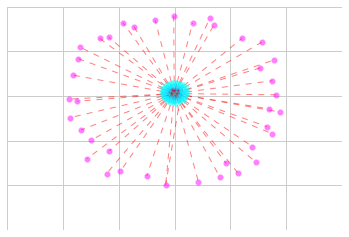

In [17]:
diff_graph('wikiconflict', idx=0)